# Class Activation Maps with Fashion MNIST

In this lab, you will see how to implement a simple class activation map (CAM) of a model trained on the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). This will show what parts of the image the model was paying attention to when deciding the class of the image. Let's begin!

In [5]:
import tensorflow as tf

In [8]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
import scipy as sp

In [9]:
# load the Fashion MNIST dataset
(X_train,Y_train),(X_test,Y_test)  = fashion_mnist.load_data()

In [10]:
# Put an additional axis for the channels of the image.
# Fashion MNIST is grayscale so we place 1 at the end. Other datasets
# will need 3 if it's in RGB.
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

# Normalize the pixel values from 0 to 1
X_train = X_train/255
X_test  = X_test/255

# Cast to float
X_train = X_train.astype('float')
X_test  = X_test.astype('float')

In [11]:
def show_img(img):
    '''utility function for reshaping and displaying an image'''

    # convert to float array if img is not yet preprocessed
    img  = np.array(img,dtype='float')

    # remove channel dimension
    img = img.reshape((28,28))

    # display image
    plt.imshow(img)

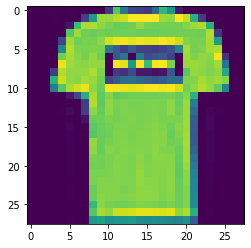

In [12]:
# test the function for the first train image. you can vary the index of X_train
# below to see other images

show_img(X_train[1])

## Build Classifier

In [15]:
# Use sequential API
model = Sequential()

# Notice the padding parameter to recover the lost border pixels whent doing the convolution
model.add(
    Conv2D(
        16, input_shape=(28, 28, 1), kernel_size=(3, 3),
        activation='relu', padding='same'
    )
)
# Pooling layer with a stride of 2 will reduce the image dimensions by half
model.add(MaxPooling2D(pool_size=(2, 2)))

# Pass through more convolutions with increasing filters
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))


# use global average pooling to take into account lesser intensity pixels
model.add(GlobalAveragePooling2D())

# output class probabilities
model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 128)        

In [16]:
# configure the training
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

# train the model. just run a few epochs for this test run. you can adjust later.
model.fit(X_train,Y_train,batch_size=32, epochs=5, validation_split=0.1, shuffle=True)

Epoch 1/5
1688/1688 [==============================] - 22s 13ms/step - loss: 0.6173 - accuracy: 0.7741 - val_loss: 0.4877 - val_accuracy: 0.8220
Epoch 2/5
1688/1688 [==============================] - 22s 13ms/step - loss: 0.3860 - accuracy: 0.8618 - val_loss: 0.3503 - val_accuracy: 0.8732
Epoch 3/5
1688/1688 [==============================] - 23s 13ms/step - loss: 0.3219 - accuracy: 0.8830 - val_loss: 0.3118 - val_accuracy: 0.8848
Epoch 4/5
1688/1688 [==============================] - 22s 13ms/step - loss: 0.2837 - accuracy: 0.8959 - val_loss: 0.2882 - val_accuracy: 0.8935
Epoch 5/5
1688/1688 [==============================] - 23s 13ms/step - loss: 0.2552 - accuracy: 0.9059 - val_loss: 0.2940 - val_accuracy: 0.8963


## Generate the Class Activation Map
- To generate the CAM, we want to get the features detected in the last convolution layer
- Observe which ones are most active when generating the output probabilities 

In [18]:
# Final Convolution Layer
print(model.layers[-3].name)

# Gloval Average Pooling Layer
print(model.layers[-2].name)

# Output of the classifier
print(model.layers[-1].name)

conv2d_5
global_average_pooling2d
dense


### Create CAM model

In [19]:
cam_model = Model(
    inputs=model.input,
    outputs=(model.layers[-3].output, model.layers[-1].output)
)
cam_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2_input (InputLayer)  [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)          0     

Use the CAM model to predict on the test set, so that it generates the features and the predicted probability for each class (`results`).

In [20]:
# Get the features and results of the test images using the newly created model
features, results = cam_model.predict(X_test)

print(f'Features shape: {features.shape}')
print(f'Results shape: {results.shape}')

Features shape: (10000, 3, 3, 128)
Results shape: (10000, 10)


You can generate the CAM by getting the dot product of the class activation feature and the class activation weights

You will need the weights from the Global Average Pooling layer(GAP) to calculate the activations of each feature given a particular class

- Note that you will get the weights from the dense layer that follows the GAP layer
 - The last conv2D layer has (h, w, depth) of (3x3x128) so there 128 features
 - The GAP layer collapses the h, w f into a dense layer of 128 neurons (1 neuron per feature)
 - The activations from the GAP layer passed to the last dense layer
 - The last dense layer assigns weights to each of those 128 features (for each of the 10 classes)
 - So the weights of the last dense layer(which immediately follows the GAP layer) are referred to in this context as the 'weights of the GAP layer"
 
For each of the 10 classes, there 128 features, so there are 128 feature weights, one weight per feature

In [22]:
# These are the weights going into the softmax layer
last_dense_layer = model.layers[-1]

# Get the weights list. Index 0 contains the weights, index 1 contains the biases
gap_weights_l = last_dense_layer.get_weights()

print("gap_weights_l index 0 contains weights ", gap_weights_l[0].shape)
print("gap_weights_l index 1 contains biases ", gap_weights_l[1].shape)

# Shows the number of features per class, and the total number of classes
# Store the weights
gap_weights = gap_weights_l[0]

print(f"There are {gap_weights.shape[0]} feature weights and {gap_weights.shape[1]} classes.")

gap_weights_l index 0 contains weights  (128, 10)
gap_weights_l index 1 contains biases  (10,)
There are 128 feature weights and 10 classes.


Now, get the features for a specific image, indexed between 0 and 999.

In [23]:
# Get the features for the image at index 0
idx = 0
features_for_img = features[idx, :, :, :]

print(f"The features for image index {idx} has shape (height, width, num of feature channels) : ", features_for_img.shape)

The features for image index 0 has shape (height, width, num of feature channels) :  (3, 3, 128)


The features have height and width of $3\times3$. Scale them up to the original image height and width, which is $28\times 28$

In [24]:
features_for_img_scaled = sp.ndimage.zoom(
    features_for_img,
    (28/3, 28/3, 1),
    order=2
)

# Check the shape after scaling up to 28x28 (still 128 feature channels)
print("features_for_img_scaled up to 28 by 28 height and width:", features_for_img_scaled.shape)

features_for_img_scaled up to 28 by 28 height and width: (28, 28, 128)


- For a particular class (0...9), get the 128 weights
- Take the dot product with the scaled features for thsi selected image with the weights
- The shapes are scaled featuere: $h\times w \times depth$ of $(28 \times 28 \times 128)$ Weights for one class: 128
- The dot product produces the class activation map, with the shape equal to the height and widht of the image: $28 \times 28$

In [26]:
# Select the weights that are used for a specific class (0...9)
class_id = 0
# Take the dot product between the scaled image features and the weights for
gap_weights_for_one_class = gap_weights[:, class_id]

print(f'features_for_image_scales has shape {features_for_img_scaled.shape}')
print(f'gap_weights_for_one_class has shape {gap_weights_for_one_class.shape}')

# Take the dot product between the scaled features and the weights for one class
cam = np.dot(features_for_img_scaled, gap_weights_for_one_class)

print(f'CAM shape {cam.shape}')

features_for_image_scales has shape (28, 28, 128)
gap_weights_for_one_class has shape (128,)
CAM shape (28, 28)


### Conceptual Interpretation
To think conceptually about what what you are doing and why
- In the $28 \times 28 \times 128$ feature map, each of the 128 feature filter is tailored to look for a specific set of features (for example, a shoelace)
    - The actual features are learned, not selected by you directly
- Each of the 128 weights for a particular class decide how much weight to give to each of the 128 features, for that class
    - for instance, for the shoe class it may have a higher weight for the feature filters that look for shoelaces
- At each of the 28 by 28 pixels, you can take the vector of 128 features and compare them with the vector of 128 weights
    - You can do this comparison with a dot product
    - The dot product results in a scaler value at each pixel
    - Apply this dot product across all of the 28 by 28 pixels
    - The scalar result of the dot product will be larger when the image both has the particular feature (eg. shoelace) and that feature is also weighted more heavily for the particular class (e.g. shoe)
    
So you have created a matrix with the same number of pixels as the image, where the value at each pixel is higher when that pixel is relevant to the prediction of a particular class


In [31]:
def show_cam(image_index):
    '''
    Displays the class activation map of a particular image
    '''
    
    # Takes the features of the chosen image
    features_for_img = features[image_index, :, :, :]
    
    # Get the class with the highest output probability
    prediction = np.argmax(results[image_index])
    
    # Get the gap weights at the predicted class
    class_activation_weights = gap_weights[:, prediction]
    
    # Upsample the features to the image's original size 28x28
    class_activation_features = sp.ndimage.zoom(features_for_img, (28/3, 28/3, 1), order=2)
    
    # Compute the intensity of each feature in the CAM
    cam_output = np.dot(class_activation_features, class_activation_weights)
    
    print(f'Predicted Class = {str(prediction)}, Probability = {str(results[image_index][prediction])}')
    
    # Show the upsampled image
    plt.imshow(np.squeeze(X_test[image_index], -1), alpha=0.5)
    
    # Strongly classified (95% probability) image will be in green else red
    if(results[image_index][prediction] > 0.95):
        cmap_str = 'Greens'
    else:
        cmap_str = 'Reds'
        
    # Overlay the cam output
    plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)
    
    plt.show()

In [32]:
def show_maps(desired_class, num_maps):
    '''
    Goes through the first 10,000 test images and generates CAMs
    for the first `num_maps`(int) of the `desired_class`(int)
    '''
    
    counter = 0
    if(desired_class < 10):
        print('Please choose a class less than 10')
        
    # Go throught the first 1000 images 
    for i in range(0, 10000):
        # break if we already displayed the specified number of maps
        if counter == num_maps:
            break
            
        # Images that match the class will be shown
        if(np.argmax(results[i]) == desired_class):
            counter += 1
            show_cam(i)

Please choose a class less than 10
Predicted Class = 2, Probability = 0.9849557


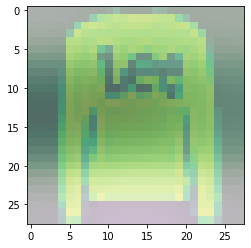

Predicted Class = 2, Probability = 0.9448533


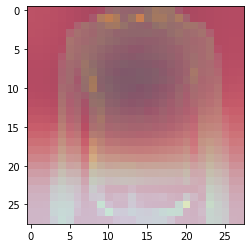

Predicted Class = 2, Probability = 0.8274722


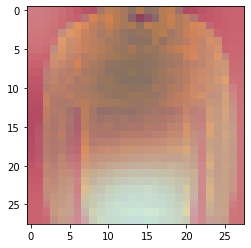

Predicted Class = 2, Probability = 0.6130082


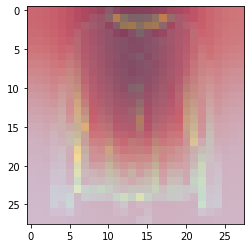

Predicted Class = 2, Probability = 0.5137277


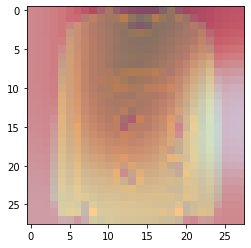

Predicted Class = 2, Probability = 0.3530028


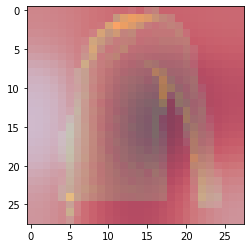

Predicted Class = 2, Probability = 0.94689393


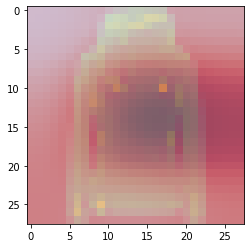

Predicted Class = 2, Probability = 0.7591075


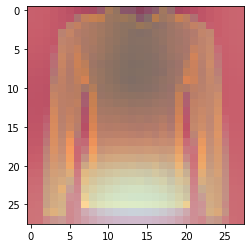

Predicted Class = 2, Probability = 0.7176438


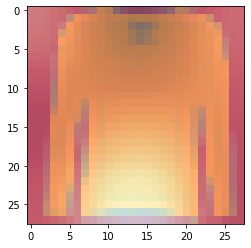

Predicted Class = 2, Probability = 0.64259696


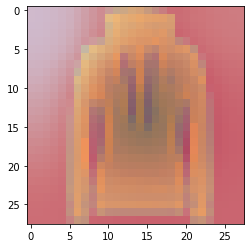

Predicted Class = 2, Probability = 0.97974485


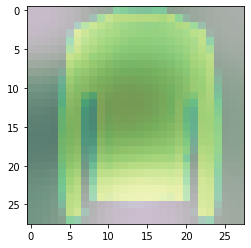

Predicted Class = 2, Probability = 0.9907007


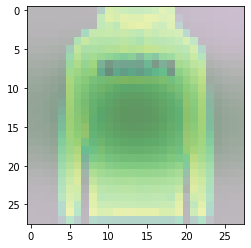

Predicted Class = 2, Probability = 0.80580676


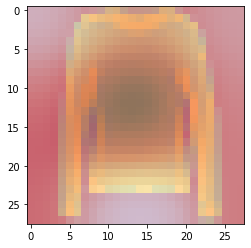

Predicted Class = 2, Probability = 0.96216756


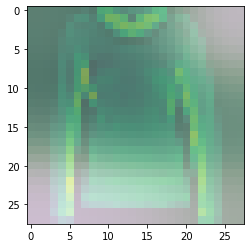

Predicted Class = 2, Probability = 0.9450252


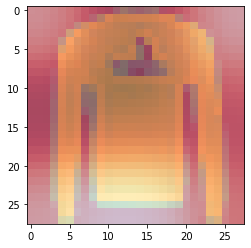

Predicted Class = 2, Probability = 0.6664999


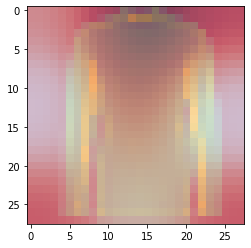

Predicted Class = 2, Probability = 0.98637855


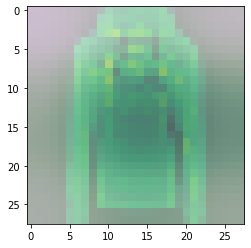

Predicted Class = 2, Probability = 0.96365666


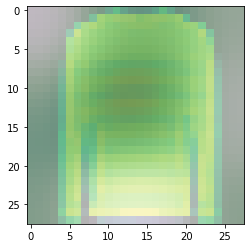

Predicted Class = 2, Probability = 0.5653544


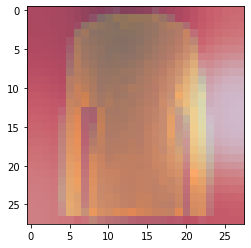

Predicted Class = 2, Probability = 0.9825525


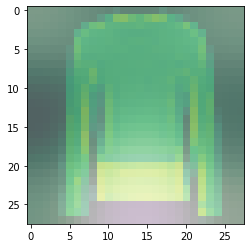

In [37]:
show_maps(desired_class=2, num_maps=20)